In [1]:
from pymongo import MongoClient
# from sshtunnel import SSHTunnelForwarder
import pymongo
from tqdm import tqdm
import os
import re

import numpy as np
import pandas as pd

import dateutil.parser
import matplotlib.pyplot as plt

In [2]:
# 使用GPU
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
! nvidia-smi

Sun Jul 17 15:41:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 27%   35C    P8    22W / 260W |     22MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 25%   

# MongoDB

In [4]:
mongoURI = "mongodb://%s:%s@%s/%s?authMechanism=SCRAM-SHA-1" % ("eva", "eva_30241", "140.117.69.70:30241", "eva")

try:
    conn = pymongo.MongoClient(mongoURI)
    db = conn.eva
    # db_de = db.patent_de
    # db_us = db.patent_us
    # db_cn = db.patent_cn

    db_us =  db.rm_patent_us
    db_cn =  db.rm_patent_cn
    db_de =  db.rm_patent_de
    
    # db_cn_5 = db.w_patent_cn_5
    # db_cn_10 = db.w_patent_cn_10
    # db_us_5 = db.w_patent_us_5
    # db_us_10 = db.w_patent_us_10
    # db_de_5 = db.w_patent_de_5
    # db_de_10 = db.w_patent_de_10
except errors.ConnectionFailure as err:
    print(err)

In [5]:
db_de

Collection(Database(MongoClient(host=['140.117.69.70:30241'], document_class=dict, tz_aware=False, connect=True, authmechanism='SCRAM-SHA-1'), 'eva'), 'rm_patent_de')

# 取得各年資料筆數

In [6]:
cn_ls=[]
de_ls=[]
us_ls=[]

for i in range(2010,2021):
    dateStr = "{}-01-01T00:00:00.000Z".format(i)
    start = dateutil.parser.parse(dateStr)

    dateEnd = "{}-12-31T00:00:00.000Z".format(i)
    end = dateutil.parser.parse(dateEnd)

    db_cn_2010 = pd.DataFrame(db_cn.aggregate( [ 
        {"$addFields": { "appDate":
                { "$dateFromString": {
                "dateString": '$appDate',
                "timezone": 'America/New_York'}
                }}
            },
            {"$match": {
                "appDate": { "$gte": start, "$lte": end }}
            },
        {"$count":"total"}
    ] ))

    cn_ls.append(db_cn_2010.values[0,0])

    db_de_2010 = pd.DataFrame(db_de.aggregate( [ 
        {"$addFields": { "appDate":
                { "$dateFromString": {
                "dateString": '$appDate',
                "timezone": 'America/New_York'}
                }}
            },
            {"$match": {
                "appDate": { "$gte": start, "$lte": end }}
            },
        {"$count":"total"}
    ] ))
    try:
        de_ls.append(db_de_2010.values[0,0])
    except:
        de_ls.append(0)

    db_us_2010 = pd.DataFrame(db_us.aggregate( [ 
        {"$addFields": { "appDate":
                { "$dateFromString": {
                "dateString": '$appDate',
                "timezone": 'America/New_York'}
                }}
            },
            {"$match": {
                "appDate": { "$gte": start, "$lte": end }}
            },
        {"$count":"total"}
    ] ))

    us_ls.append(db_us_2010.values[0,0])



    print(dateStr)

2010-01-01T00:00:00.000Z
2011-01-01T00:00:00.000Z
2012-01-01T00:00:00.000Z
2013-01-01T00:00:00.000Z
2014-01-01T00:00:00.000Z
2015-01-01T00:00:00.000Z
2016-01-01T00:00:00.000Z
2017-01-01T00:00:00.000Z
2018-01-01T00:00:00.000Z
2019-01-01T00:00:00.000Z
2020-01-01T00:00:00.000Z


In [7]:
print("us_ls",us_ls)
print("de_ls",de_ls)
print("cn_ls",cn_ls)

us_ls [30, 123, 156, 178, 660, 2001, 3555, 5127, 7828, 10539, 8455]
de_ls [0, 0, 7, 7, 12, 37, 88, 199, 230, 242, 243]
cn_ls [266, 558, 852, 968, 845, 1486, 2884, 6557, 6741, 7486, 7692]


# 畫出歷年折線圖

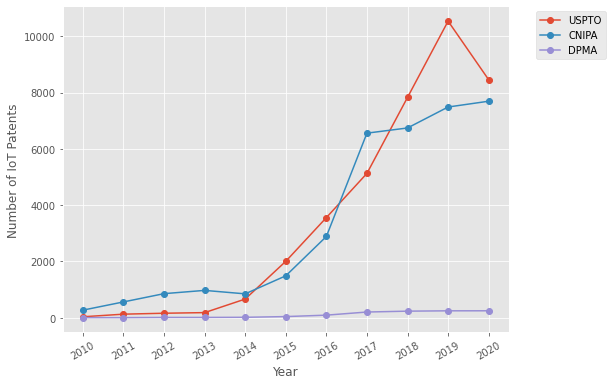

In [8]:
plt.figure(figsize=(8,6))
plt.style.use('ggplot')

plt.plot(us_ls,"-o",label="USPTO")
plt.plot(cn_ls,"-o",label="CNIPA")
plt.plot(de_ls,"-o",label="DPMA")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xticks(range(0,11),labels=list(range(2010,2021)),rotation=30)
plt.xlabel("Year")
plt.ylabel("Number of IoT Patents")

plt.show()